# Gaussian Mixture Model vs. KMeans

**Assignment**: Comparison of the KMeans method and GMM for clustering using the Fashion-MNIST dataset. Explore the parameters of GMM.

<hr>

### Table of Content

- **0. Introduction**
    - Task Description
    - Importing Modules
    
    
- **1. Importing the Dataset**
    - Importing
    - Data Pre-Processing


- **2. Implementing our own gridsearch**


- **3. Implementation of KMeans**
    - Simple Implementation From Scratch (without gridsearch)
    - Implementation using SciKit-Learn
    
    
- **4. Implementation of GMM**
    - Simple Implementation From Scratch (without gridsearch)
    - Implementation using SciKit-Learn
    
    
- **5. Comparing the best results of both KMeans and GMM**


- **6. Exploring the parameters of GMM, i.e. Implementing Efficient Greedy Learning**


- **7. References**

<hr>

## 0. Introduction

### 0.1 Task Description

### 0.2 Importing Modules

In [1]:
from keras.datasets import fashion_mnist

from itertools import cycle
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## 1. Importing the dataset: Fashion-MNIST

### 1.1. Importing

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [3]:
labelNames = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

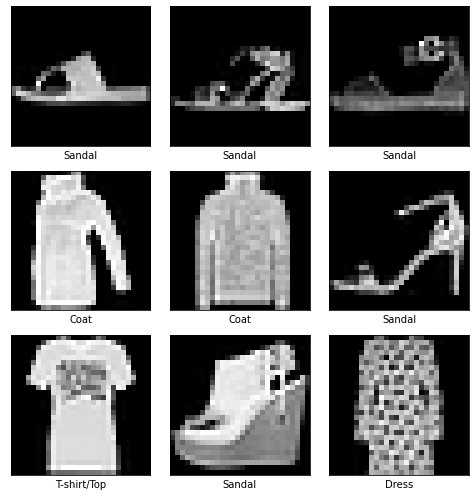

In [4]:
#Sample images
length = 3
plt.figure(figsize=(7, 7)) 
for i in range(length * length):
    temp = rd.randint(0, len(x_train)+1)
    image = x_train[temp] 
    plt.subplot(length, length, i+1)       
    plt.imshow(image, cmap='gray')  
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labelNames[y_train[temp]])
    plt.tight_layout()   
plt.show()

### 1.2. Data Preprocessing

**Normalization**: Each item in the dataset is a grayscale picture (1 channel) where each pixel is a value lying between $0$ and $255$. We need to rescale each image to the [0,1] range, i.e., normalize our images. This rescaling is done by dividing each pixel value by 255.

In [5]:
# Before
print(f"One pixel before normalization: {x_train[0][5][15]}")

# Normalization
x_train = x_train / 255.
x_test = x_test / 255.

# After
print(f"One pixel after normalization: {x_train[0][5][15]}")

One pixel before normalization: 204
One pixel after normalization: 0.8


**Flattening**: Since each image is a 2d picture of 28 pixels by 28, we need to reshape our data so it can be fed in a model. To do so, we reshape our image into a single dimension of size 28\*28, i.e. 784.

In [6]:
x_train_processed = x_train.reshape(len(x_train), 784)
x_test_processed = x_test.reshape(len(x_test), 784)

print(f"Shape of x_train_processed: {x_train_processed.shape}")
print(f"Shape of x_test_processed: {x_test_processed.shape}")

Shape of x_train_processed: (60000, 784)
Shape of x_test_processed: (10000, 784)


## 2. Implementing a Clustering GridSearch

In [7]:
class GridSearch():
    def __init__(self, model, hyperparameters, n_jobs):
        """
        
        """
        if model == "kmeans":
            self.model = "kmeans"
        else:
            self.model = "gaussian"
        self.hyperparameters = hyperparameters
        self.n_jobs = n_jobs
        self.training_results = {}
    
    def fit(self, x_train, y_train):
        """
        
        """
        model_number = 0
        if self.model=="kmeans":
            for component in self.hyperparameters["n"]:
                for initialization in hyperparameters["init"]:
                    for algorithm in hyperparameters["algorithm"]:
                        model_number += 1
                        model = KMeans(n_clusters=component, 
                                       init=initialization, 
                                       algorithm=algorithm,
                                       n_jobs=self.n_jobs,
                                       random_state=0)
                        model.fit(x_train)
                        h_score, v_score, sil_score = self.scoring(model, x_train, y_train)
                        print(f"KMeans #{model_number} trained with {component} components, " + 
                              f"{initialization} initialization and {algorithm} algorithm, " +
                              f"yielding homogeneity, v_measure and silhouette scores of {h_score}, " +
                              f"{v_score} and {sil_score} resp.")
                        self.training_results[model_number] = {"n_clusters": component, 
                                                               "init": initialization, 
                                                               "algorithm": algorithm, 
                                                               "model": model,
                                                               "homogeneity_score": h_score,
                                                               "v_measure_score": v_score}
        else:
            for component in hyperparameters["n"]:
                for covariance in hyperparameters["covariance_type"]:
                    model_number += 1
                    model = GaussianMixtureModel(n_components=component, 
                                                 covariance_type=covariance,
                                                 n_jobs=self.n_jobs,
                                                 random_state=0)
                    model.fit(x_train)
                    h_score, v_score, sil_score = self.scoring(model, x_train, y_train)
                    print(f"GMM #{model_number} trained with {component} components and cov. type {covariance}, " +
                          f"yielding homogeneity, v_measure and silhouette scores of {h_score}, {v_score} and " + 
                          f"{sil_score} resp.")
                    self.training_results[model_number] = {"n_components":component, 
                                                           "covariance_type":covariance, 
                                                           "model": model,
                                                           "homogeneity_score": h_score,
                                                           "v_measure_score": v_score}
        
        return self.training_results
        
    def scoring(self, model, X, y):
        """
        
        """
        y_pred = model.predict(X)
        v_score = v_measure_score(y, y_pred)
        h_score = homogeneity_score(y, y_pred)
        sil_score = silhouette_score(X, y_pred, metric='euclidean')
        return h_score, v_score, sil_score
    
    def predict(self, model_number, x_test, y_test):
        """
        
        """
        model = self.training_results[model_number]["model"]
        h_score, v_score, sil_score = self.scoring(model, x_test, y_test)
        print(f"GMM #{model_number} yielded homogeneity, v_measure and silhouette scores "+
              f"of {h_score}, {v_score} and {sil_score} resp. on the test set")
        return model.predict(x_test)

## 3. Implementation of KMeans




### 3.1. Simple Implementation From Scratch (without gridsearch)

First of all, let's build our own KNN to see how it works. Using the ``make_blobs`` function from the SciKit-Learn library we implement a Kmeans using euclidian distance metrics.

In [8]:
def generate_data(number_of_points):
    """
    Generates a set of 2-dimensional coordinates, their x and y axes random values between 0 and 99.
    The set is generate with a random number of centers (between 2 and 9)
    """
    X, _ = make_blobs(n_samples=number_of_points, centers=rd.randint(2,10), n_features=2, random_state=0)
    return X

def compare_dict(dict1, dict2):
    """
    Compares two dictionaries, asserting that they are identical or not.
    """
    for key in dict1.keys():
        if not np.array_equal(dict1[key], dict2[key]): return False
    return True

def euclidian_distance(p1, p2):
    """
    Calculates the euclidian distance between two points in the R² space.
    """
    distance = 0
    for idx, item in enumerate(p1): 
        distance += (item - p2[idx]) ** 2
    return math.sqrt(distance)

In [9]:
class k_means():
    def __init__(self, nb_of_data_points, k=2):
        """
        Initializes the k-means class.
        """
        self.data = generate_data(nb_of_data_points)
        self.k = k
        self.colors = cycle(["g","r","b","c","m","y"])
        self.iterated = 0
        
        # Generates an empty dictionary to store each step's centroids
        self.model_centroids = {}
        
        # Generates an empty dictionary to store each step's classification
        self.model_classifications = {}
    
    
    def fit(self, max_iterations=100):
        """
        Fits the model.
        """
        self.iterated = 0
        
        # Select the initial k centroids
        centroids = rd.sample(list(self.data), 2)
        
        # Iterates to fit the model
        for iteration in range(max_iterations):
            print(f"Epoch {iteration}")
            
            # Generates an empty dictionary to store the step's classification
            step_classification = {}
            for k in range(self.k): step_classification[k] = []
            
            # Calculates the euclidian distance between each data points and each centroids
            # Records the points in the classification corresponding to its nearest centroid
            for point in self.data:
                distances = list(map(lambda x: euclidian_distance(point, x), centroids))
                argmin = min(range(len(distances)), key=distances.__getitem__)
                step_classification[argmin].append(point)
            
            # Records the state of the model after the iteration's fitting
            self.model_centroids[iteration] = centroids
            self.model_classifications[iteration] = step_classification
            
            # If no change has been identified between this iteration and the last, the model will stop.
            if len(self.model_classifications)>1:
                if compare_dict(self.model_classifications[iteration],
                                self.model_classifications[iteration-1]):
                    self.iterated = iteration
                    print(f"No significant change has been achieved during epoch {self.iterated}. "+\
                          "Model is considered fitted.")
                    break
            
            # Updates the centroids
            centroids = []
            for classification in step_classification.values():
                if classification == []: centroids.append(np.zeros(3))
                else: centroids.append(np.mean(classification, axis=0))
       
    
    def plot_data(self):
        """
        Plots the distribution of the data
        """
        # Declares the plot
        plt.figure(figsize=(6,6))

        # Plots the data without colors if the dataset was not iterated over.
        if self.model_centroids == {} or self.iterated == 0:
            plt.scatter(self.data[:,0],self.data[:,1])

        else:
            # Plots the centroids first
            for centroid in self.model_centroids[self.iterated]:
                plt.scatter(centroid[0], centroid[1], 
                            marker="o", color="k", s=50, linewidths=5)

            # plots the data points
            for classification in self.model_classifications[self.iterated].values():
                color = next(self.colors)
                for feature in classification:
                    plt.scatter(feature[0], feature[1], 
                                marker='x', color=color, s=20, linewidths=2)
        plt.show()

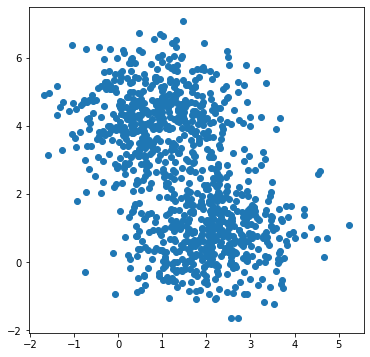

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
No significant change has been achieved during epoch 41. Model is considered fitted.


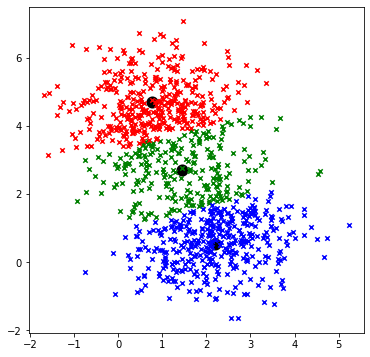

In [10]:
model = k_means(1000, 3)
model.plot_data()
model.fit()
model.plot_data()

### 3.2. Implementation using SciKit-Learn

Now that we know how it works, we can apply the KNN model offered by the SciKit-Learn library onto the Fashion MNIST dataset.

In [11]:
hyperparameters = {"n":range(8,15),
                   "init":["k-means++","random"],
                   "algorithm":["full", "elkan"]}

In [12]:
grid_search = GridSearch("kmeans", hyperparameters, n_jobs=-1)

In [ ]:
results = grid_search.fit(x_train_processed, y_train)

KMeans #1 trained with 8 components, k-means++ initialization and full algorithm, yielding homogeneity, v_measure and silhouette scores of 0.4745128989093765, 0.5021663615207347 and 0.15434901811491045 resp.
KMeans #2 trained with 8 components, k-means++ initialization and elkan algorithm, yielding homogeneity, v_measure and silhouette scores of 0.4745128989093765, 0.5021663615207347 and 0.15434901811491045 resp.
KMeans #3 trained with 8 components, random initialization and full algorithm, yielding homogeneity, v_measure and silhouette scores of 0.4909088947714878, 0.5289507374428093 and 0.17118687018602335 resp.
KMeans #4 trained with 8 components, random initialization and elkan algorithm, yielding homogeneity, v_measure and silhouette scores of 0.4909088947714878, 0.5289507374428093 and 0.17118687018602335 resp.
KMeans #5 trained with 9 components, k-means++ initialization and full algorithm, yielding homogeneity, v_measure and silhouette scores of 0.4771908656895545, 0.49534918865

In [ ]:
print("Predicting fashion items on the test set")
y_pred = grid_search.predict(2, x_test_processed, y_test)

In [ ]:
label_number = len(np.unique(y_pred))

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(label_number)]
for i, label in enumerate(y_pred):
    for n in range(label_number):
        if label == n: cluster_index[n].append(i)
        else: continue

for j, _ in enumerate(labelNames):
    plt.figure(figsize=(3,3));
    clust = j #enter label number to visualise T-Shirt/Top
    num = 10
    for i in range(1,num):
        plt.subplot(1, 1, i) #(Number of rows, Number of column per row, item number)
        plt.imshow(x_test_processed[cluster_index[clust][i+20]].reshape(x_test.shape[1], x_test.shape[2]), cmap = plt.cm.binary);

    plt.show()

## 4. Implementation of GMM

### 4.1. Simple Implementation From Scratch (without gridsearch)

### 4.2. Implementation using SciKit-Learn

In [ ]:
hyperparameters = {"n_components":range(10,21),
                   "covariance_type":["full", "tied", "diag", "spherical"]}

grid_search = GridSearch("gmm", hyperparameters, n_jobs=-1)
results = grid_search.fit(x_train_processed, y_train)
print("Best estimator found by grid search:")
print(grid_search.best_estimator_)

print("Best score found by grid search:")
print(grid_search.best_score_)

print("Best parameters found by grid search:")
print(grid_search.best_params_)
print("Predicting fashion items on the test set")
y_pred = grid_search.predict(x_test_processed)

In [ ]:
grid_search = GridSearch("gmm", hyperparameters, n_jobs=-1)

In [ ]:
results = grid_search.fit(x_train_processed, y_train)

In [ ]:
print("Best estimator found by grid search:")
print(grid_search.best_estimator_)

print("Best score found by grid search:")
print(grid_search.best_score_)

print("Best parameters found by grid search:")
print(grid_search.best_params_)

In [ ]:
print("Predicting fashion items on the test set")
y_pred = grid_search.predict(x_test_processed)

In [ ]:
label_number = 10

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(label_number)]
for i, label in enumerate(y_pred):
    for n in range(label_number):
        if label == n: cluster_index[n].append(i)
        else: continue

for j, _ in enumerate(labelNames):
    plt.figure(figsize=(6,6));
    clust = j #enter label number to visualise T-Shirt/Top
    num = 10
    for i in range(1,num):
        plt.subplot(3, 3, i) #(Number of rows, Number of column per row, item number)
        plt.imshow(x_test_processed[cluster_index[clust][i+20]].reshape(x_test.shape[1], x_test.shape[2]), cmap = plt.cm.binary);

    plt.show()

## 5. Comparing the best results of both KMeans and GMM

## 6. Exploring the parameters of GMM, i.e. Implementing Efficient Greedy Learning

Based on ``Verbeek, Jakob & Vlassis, Nikos & Krose, B.. (2003). Efficient Greedy Learning of Gaussian Mixture Models. Neural computation. 15. 469-85. 10.1162/089976603762553004``.

## 7. References used for this exercise

- https://www.researchgate.net/publication/10896453_Efficient_Greedy_Learning_of_Gaussian_Mixture_Models
- https://www.kaggle.com/c/ttic-31020-hw5-fmnist-gmm/leaderboard (leaderboard for GMM classification of Fashion-MNIST)
- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html